# Speech Signal Processing— Exercise 6 —Speech Enhancement

This exercise deals with single-channel speech enhancement techniques. Such methods usually apply the Fourier
transform on short time-frames, which you already generated in the first and second exercise. Then, the noise
components are suppressed in the spectral domain. The same holds for this exercise where the short-time
spectra are used to estimate the power spectral density (PSD) of the background noise using a speech presence
probability (SPP) based estimator. From this, the a posteriori signal-to-noise ratio (SNR) is determined with the
decision-directed (DD) approach. Finally, both quantities are used to design the gain-function of the Wiener-filter
which is applied to the noisy spectrum to achieve the desired noise reduction.

Download the file Exercise6.zip from STiNE which contains two speech signals which are corrupted once by
white noise and once by babble noise. For both files the signal-to-noise ratio (SNR) is 10 dB.

## 1 Noise Power Estimation

In this part of the exercise, the noise power is estimated based on the speech presence probability. First, use your
functions from the first and the second exercise to create
√hann the STFT of the noisy input signals. The frame length
should be 32 ms and the frame shift 16 ms. Use a Hann-window as analysis window. It can be generated
using sqrt(hann(FrameLength, ’periodic’)) where FrameLength is the frame length converted to samples. From
the STFT, compute the periodograms and determine the noise PSD by performing the following steps for each
frame.

In [11]:
#imports
import scipy.io
import numpy as np
from scipy.signal import lfilter, freqz, stft, hanning
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import Audio, display
import wave
import sys
import sounddevice as sd
import matplotlib as mpl

#read-Objekte
file_white = wave.open('./Audio/SpeechWhite.wav','r')
file_babble = wave.open('./Audio/SpeechBabble.wav','r')

#Abtastwerte
white_samples = np.frombuffer(file_white.readframes(-1),'int16')
babble_samples = np.frombuffer(file_babble.readframes(-1),'int16')

#Abtastrate
white_fs = file_white.getframerate()
babble_fs = file_babble.getframerate()

#Time-Domain
white_time = np.linspace(0, len(white_samples)/white_fs, num=len(white_samples))
babble_time = np.linspace(0, len(babble_samples)/babble_fs, num=len(babble_samples))

#sound white
#sd.play(white_samples, white_fs)
#sd.play(babble_samples, white_fs)

1.Compute the posterior probability of speech presence via

P(H_1|Y[k,l]) = ...

Here, |Y[k,l]|hoch 2 denotes the periodogram of the noisy input signal and σ̂ n is the estimated PSD of the
background noise. Furthermore, k indexes the frequency bins and l the frames. The SNR between speech
and noise which is assumed in speech presence is denoted by θ. This value should be set to 15 dB.

2.In order to avoid stagnations, a smoothed posterior probability Q[k,l] is required which is given as


Q[k,l] = ...


For every frequency bin in the current frame l for which Q[k, l] > 0.99 holds, set your computed posterior
P (H 1 |Y [k, l]) from equation (1) to min(0.99, P (H 1 |Y [k, l])).

3.Estimate the noise periodogram via


| N̂ [k, l]| 2 = .. 


and update the noise power density with

σ̂ 2n[k,l] =... 

Store every estimated noise PSD in a matrix matNoisePSD as it may simplify solving the following questions.

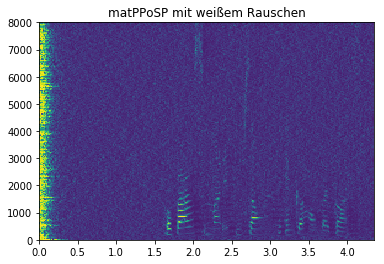

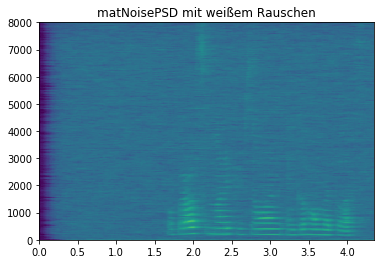

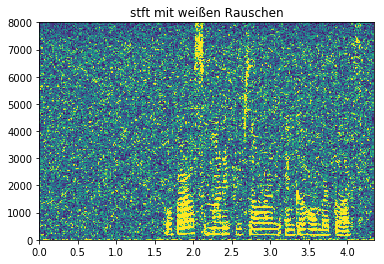

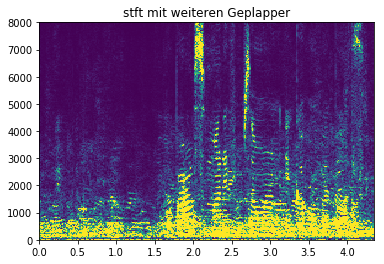

In [75]:
###########Parameter###############
frame_len_sec = 32e-3
frame_shift_sec = 16e-3
theta = 15

######### Funktionen###############
def noise_psd(samples,fs):
    f,t,Zx = spec_stft(samples,fs)
    frame_len = len(Zx[0])
    frame_nu = len(Zx)
   
    #PSD Matrix und posterior probility of speech presence
    matNoisePSD = np.copy(Zx); #Zunächst eine Copy von Zx
    matPPoSP = np.copy(Zx);

    #aktueller Noise Power und aktueller geglättetes PPoSP
    anp = np.array([1] * frame_len);
    PPoSP_smoothed= np.array([0] * frame_len);
    
    
    for k in range(0,frame_nu):
        pd = np.sqrt(np.abs(Zx[k])) # periodogramm
        apposp = 1 / (1 + (1 + theta) * np.exp(-pd / anp * theta/(1 + theta))); # posterior probability of speech presence
        PPoSP_smoothed = PPoSP_smoothed * 0.9 + 0.1 * apposp;
        
        for l in range(0,frame_len):
            if PPoSP_smoothed[l] > 0.99:
                apposp[l] = min(0.99,apposp[l])
        npd = apposp * anp + (1-apposp) * pd;
        anp = 0.8*anp + 0.2*npd;
        matPPoSP[k] = apposp;
        matNoisePSD[k] = anp;
        
    return f, t, matPPoSP, matNoisePSD,
    
def spec_stft(samples,fs):
    frame_len = int (frame_len_sec * fs)
    frame_shift = int (frame_shift_sec * fs)
    #sym=False in hanning macht es periodisch, statt symmetrisch
    win = np.sqrt(hanning(frame_len,sym=False))
    f,t,Zxx = stft(samples,fs=fs,window=win,nperseg=frame_len,noverlap=frame_shift)
    Zx = [np.append(i,i[1:][::-1]) for i in np.transpose(Zxx)]
    return f,t,Zx

########## Test ###############################
f0,t0,matPPoSP,matNoisePSD = noise_psd(white_samples,white_fs)
plt.title('matPPoSP mit weißem Rauschen')
plt.pcolormesh(t0, f0, np.abs(np.transpose(matPPoSP)[:len(f0)]),vmin=0, vmax=1)
plt.show()

plt.title('matNoisePSD mit weißem Rauschen')
plt.pcolormesh(t0, f0, np.abs(np.transpose(10 * np.log(matNoisePSD))[:len(f0)]),vmin=0, vmax=50)
plt.show()



########### gewöhnlicher STFT##################
f1,t1,Wx = spec_stft(white_samples,white_fs)
f2,t2,Bx = spec_stft(babble_samples,babble_fs)
#Zxx ist nicht das vollständige fft... also:
plt.title('stft mit weißen Rauschen')
plt.pcolormesh(t, f, np.abs(np.transpose(Wx)[:len(f)]),vmin=0, vmax=100)
plt.show()
plt.title('stft mit weiteren Geplapper')
plt.pcolormesh(t, f, np.abs(np.transpose(Bx)[:len(f)]),vmin=0, vmax=100)
plt.show()

Questions
1.1 In equation (1), (3) and (4) the noise power estimate from the previous frame, σ̂ n 2 [k, l − 1], is required.
However, there is none available for the first frame l = 0. The same problem occurs for the smoothed speech
presence probability Q[k, l] in (2).

• What would be appropriate initializations for the first noise estimate σ̂ n 2 [k, −1] and the smoothed
posterior probability Q[k, −1]? Explain briefly why you chose your initialization method.


1.2 Plot the speech presence probability P (H 1 |Y [k, l]) using imagesc .

a) Which values do you obtain for time-frequency points where speech is present?

b) What values do you get for time-frequency points where only noise is present?

c) If you compare the speech presence probability with the spectrogram of your input signal, can you see
similarities?


1.3 Plot the estimated noise PSD as a spectrogram using imagesc .

a) How well is the background noise estimated?

b) Can you observe errors (e. g. components that do not belong to the background noise)?

c) What would be the consequence of such errors?